## Motores Elétricos - Predição de Falhas

### Desenvolvimento de um Modelo de Machine Learning para Prever Falhas em Motores Elétricos Considerando Múltiplos Atributos

Este guia fornece um passo a passo detalhado para desenvolver um modelo de machine learning que prevê falhas em motores elétricos antes que elas ocorram, considerando múltiplos atributos. O processo inclui desde a criação e análise dos dados até a implementação do modelo em produção, com exemplos de código, plotagens de gráficos e explicações detalhadas.

In [1]:
# 1 - Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Balanceamento de dados
from imblearn.over_sampling import SMOTE

# Salvamento do modelo
import pickle

# Ignorar avisos
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 2. Criação e Carregamento dos Dados

# Definindo o número de amostras
num_samples = 10000

# Gerando dados sintéticos
np.random.seed(42)  # Para reprodutibilidade
data = pd.DataFrame({
    'ambient': np.random.uniform(20, 40, num_samples),
    'coolant': np.random.uniform(20, 80, num_samples),
    'u_d': np.random.uniform(-300, 300, num_samples),
    'u_q': np.random.uniform(-300, 300, num_samples),
    'motor_speed': np.random.uniform(0, 4000, num_samples),
    'torque': np.random.uniform(0, 200, num_samples),
    'i_d': np.random.uniform(-200, 200, num_samples),
    'i_q': np.random.uniform(-200, 200, num_samples),
    'pm': np.random.uniform(20, 200, num_samples),
    'stator_yoke': np.random.uniform(20, 200, num_samples),
    'stator_tooth': np.random.uniform(20, 200, num_samples),
    'stator_winding': np.random.uniform(20, 200, num_samples)
})

# Adicionando um timestamp simulado
data['timestamp'] = np.arange(len(data))

# **Adicionando aqui a definição da variável alvo 'failure'**

def determine_failure(row):
    conditions = [
        (row['pm'] > 150) and (row['torque'] > 150),
        (row['i_q'] > 180) and (row['motor_speed'] < 500),
        (row['stator_winding'] > 160) and (row['coolant'] > 70),
        (row['u_d'] > 250) and (row['u_q'] > 250),
        (row['ambient'] > 35) and (row['stator_tooth'] > 170),
    ]
    return int(any(conditions))

data['failure'] = data.apply(determine_failure, axis=1)

# Salvando o DataFrame em um arquivo CSV
data.to_csv('motor_temperature_data.csv', index=False)

# Carregando os dados do arquivo CSV
data = pd.read_csv('motor_temperature_data.csv')

In [3]:
# 3 - Análise Exploratória de Dados (EDA)
## 3.1 - Visualização das Primeiras Linhas
data.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,timestamp,failure
0,27.490802,42.418449,137.998987,82.886741,1195.648165,169.447316,96.622081,-182.935559,167.269601,177.888648,124.540228,26.952510,0,1
1,39.014286,39.974726,-189.292803,-24.424528,379.271101,98.903409,152.440750,131.401848,46.148557,183.291039,114.854897,39.605115,1,0
2,34.639879,30.569235,-92.016183,278.699115,505.436900,39.093122,-14.728050,-100.276967,190.363483,88.107018,83.186651,97.849362,2,0
3,31.973170,56.436000,97.968382,-168.612929,722.684513,147.328357,-84.328507,-86.425054,171.780341,61.693530,108.778278,190.319713,3,0
4,23.120373,48.597450,-10.746393,52.713850,814.613337,83.735627,-72.461370,-109.501889,185.393594,54.498989,85.717394,33.478754,4,0


In [4]:
## 3.2 - Resumo estatístico
data.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,timestamp,failure
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,29.883191,50.271793,0.030237,-0.771970,1987.455222,100.628918,0.715246,-0.310209,110.187803,109.165692,110.048682,110.335329,4999.50000,0.156200
std,5.752603,17.357673,172.064254,173.396754,1157.136715,57.668258,115.063168,114.387225,52.497592,51.792161,51.889125,52.283241,2886.89568,0.363063
min,20.000233,20.009465,-299.971126,-299.996678,0.066945,0.001686,-199.891951,-199.947995,20.023188,20.005283,20.017622,20.004955,0.00000,0.000000
25%,24.926577,35.236748,-147.751253,-151.885651,977.088888,51.391295,-98.446104,-99.200637,63.888817,64.078448,64.394617,64.932745,2499.75000,0.000000
50%,29.850572,50.353807,1.240857,0.018144,1974.868769,101.218078,1.683778,-0.307425,110.762804,109.387910,110.553418,110.421105,4999.50000,0.000000
75%,34.800127,65.388753,146.804312,148.269752,3001.908135,150.689194,100.987675,99.128800,156.618935,153.609923,154.990836,156.171711,7499.25000,0.000000
max,39.994353,79.995490,299.940586,299.873623,3999.888589,199.987939,199.875951,199.950040,199.998568,199.995675,199.959577,199.975261,9999.00000,1.000000


In [5]:
## 3.3 - Informações sobre o conjunto de dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ambient         10000 non-null  float64
 1   coolant         10000 non-null  float64
 2   u_d             10000 non-null  float64
 3   u_q             10000 non-null  float64
 4   motor_speed     10000 non-null  float64
 5   torque          10000 non-null  float64
 6   i_d             10000 non-null  float64
 7   i_q             10000 non-null  float64
 8   pm              10000 non-null  float64
 9   stator_yoke     10000 non-null  float64
 10  stator_tooth    10000 non-null  float64
 11  stator_winding  10000 non-null  float64
 12  timestamp       10000 non-null  int64  
 13  failure         10000 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 1.1 MB


In [6]:
## 3.4 - Análise de valores nulos
data.isnull().sum()

ambient           0
coolant           0
u_d               0
u_q               0
motor_speed       0
torque            0
i_d               0
i_q               0
pm                0
stator_yoke       0
stator_tooth      0
stator_winding    0
timestamp         0
failure           0
dtype: int64

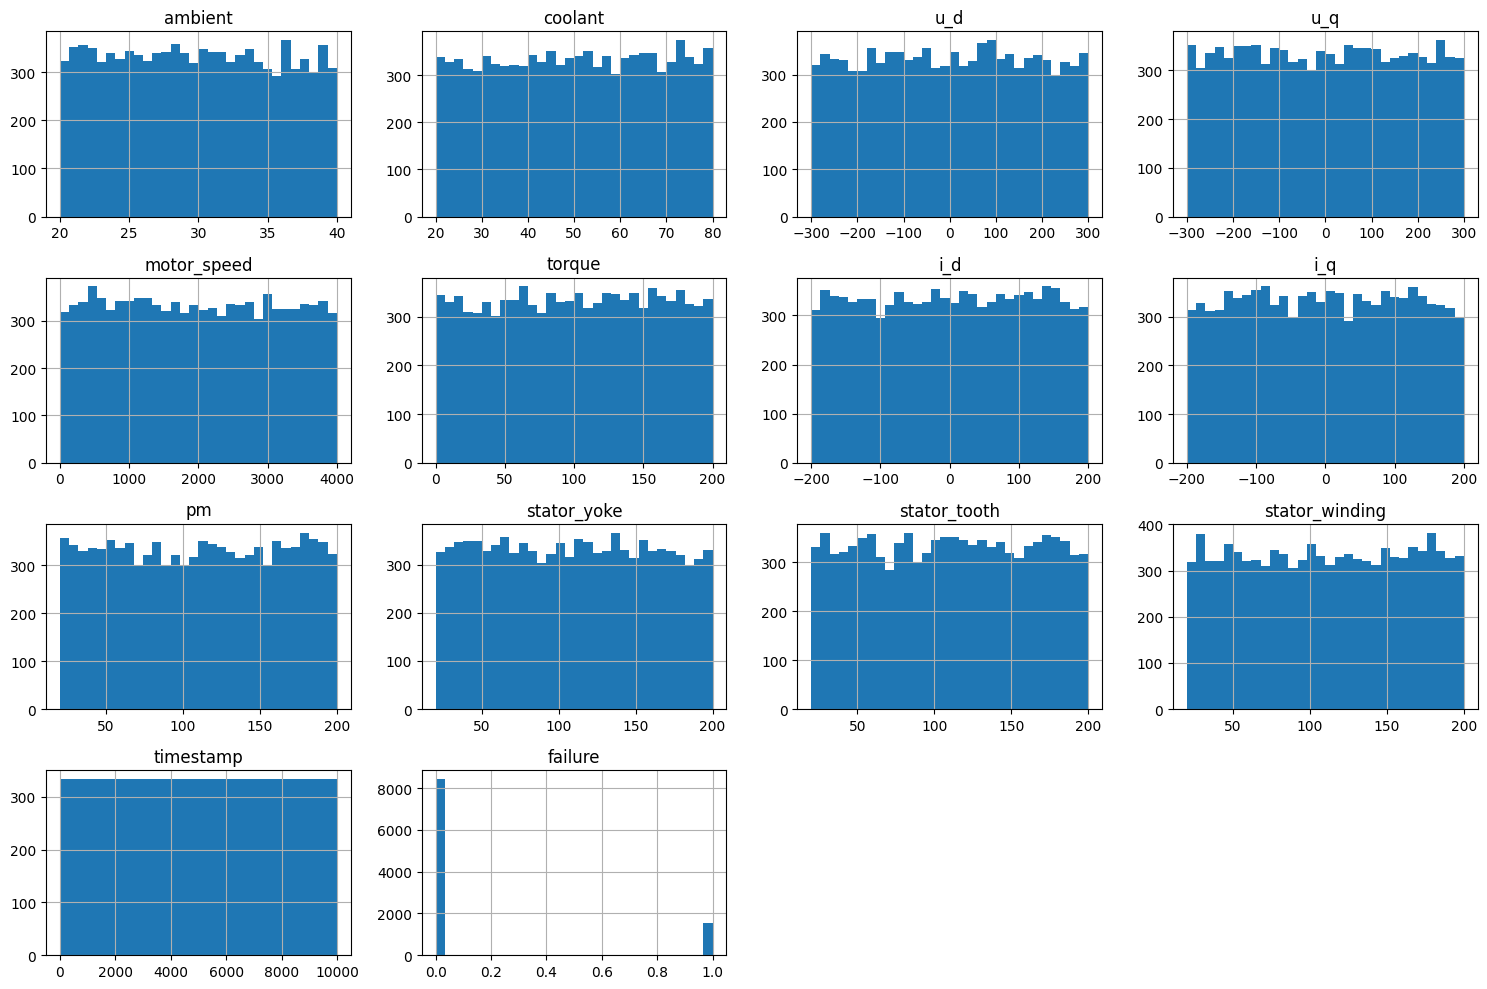

In [7]:
## 3.5. Distribuição das Variáveis
# Plotando histogramas para visualizar a distribuição das variáveis numéricas.
data.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

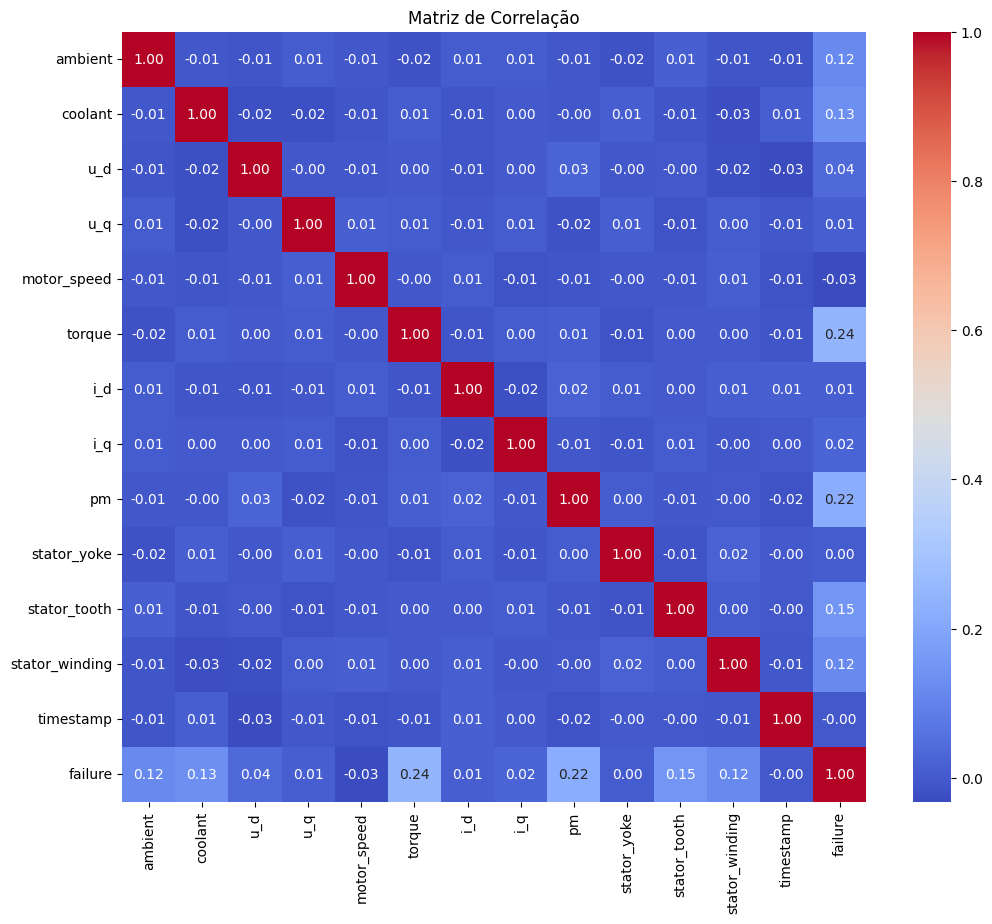

In [8]:
## 3.6. Análise de Correlação
# Visualizando a matriz de correlação para entender as relações entre as variáveis.
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

In [9]:
# 4. Pré-processamento dos Dados

# 4.1. Tratamento de Dados Faltantes
# Não temos dados faltantes, mas se tivéssemos, poderíamos usar:
# Imputação com a média
data.fillna(data.mean(), inplace=True)

## 4.2. Engenharia de Atributos
# Adicionando features que podem ajudar o modelo a capturar tendências e padrões.

### 4.2.1. Features de Tendência
# Calculando a diferença e a taxa de variação da temperatura do ímã permanente.
data['pm_diff'] = data['pm'].diff().fillna(0)
data['pm_rate'] = data['pm_diff'] / (data['timestamp'].diff().fillna(1))


In [10]:
## 4.3. Redefinição da Variável Alvo
# Criando uma função para determinar se uma instância representa uma falha, considerando múltiplos atributos.
def determine_failure(row):
    conditions = [
        (row['pm'] > 150) and (row['torque'] > 150),
        (row['i_q'] > 180) and (row['motor_speed'] < 500),
        (row['stator_winding'] > 160) and (row['coolant'] > 70),
        (row['u_d'] > 250) and (row['u_q'] > 250),
        (row['ambient'] > 35) and (row['stator_tooth'] > 170),
    ]
    return int(any(conditions))

data['failure'] = data.apply(determine_failure, axis=1)

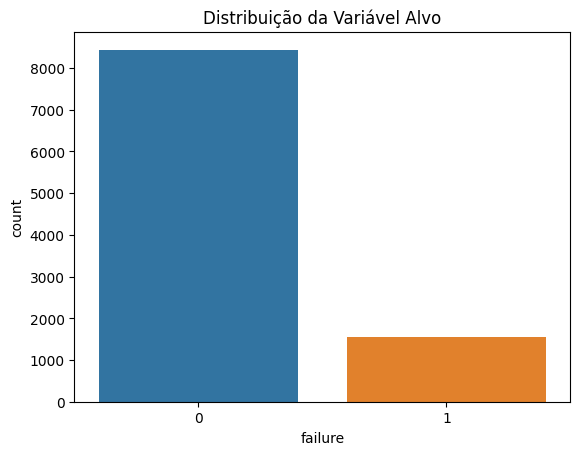

failure
0    8438
1    1562
Name: count, dtype: int64

In [11]:
## 4.4. Verificação e Tratamento de Dados Desbalanceados
### 4.4.1. Verificação da Distribuição da Variável Alvo
sns.countplot(x='failure', data=data)
plt.title('Distribuição da Variável Alvo')
plt.show()

# Contagem das classes
data['failure'].value_counts()

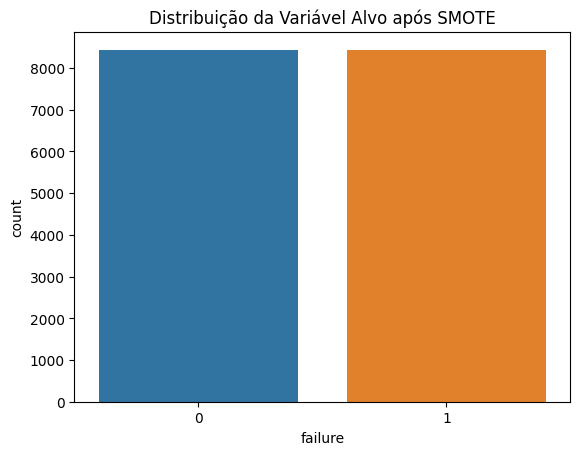

In [12]:
### 4.4.2. Balanceamento dos Dados com SMOTE
# Separando features e target
features = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque',
            'i_d', 'i_q', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding',
            'pm_diff', 'pm_rate']

X = data[features]
y = data['failure']

# Aplicando SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Verificando a nova distribuição
sns.countplot(x=y_res)
plt.title('Distribuição da Variável Alvo após SMOTE')
plt.show()

In [13]:
## 4.5. Padronização dos Dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

In [14]:
# 5. Divisão dos Dados em Conjuntos de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)

In [15]:
# 6. Treinamento e Ajuste dos Modelos
## 6.1. Modelo 1: Random Forest
### 6.1.1. Treinamento Inicial
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
### 6.1.2. Ajuste de Hiperparâmetros com GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Melhores parâmetros para Random Forest:", grid_rf.best_params_)

Melhores parâmetros para Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [17]:
## 6.2. Modelo 2: Support Vector Machine (SVM)
### 6.2.1. Treinamento Inicial
svc = SVC(random_state=42)
svc.fit(X_train, y_train)

SVC(random_state=42)

In [18]:
## 6.2.2. Ajuste de Hiperparâmetros com GridSearchCV
param_grid_svc = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf']
}

grid_svc = GridSearchCV(SVC(random_state=42), param_grid_svc, cv=5, n_jobs=-1)
grid_svc.fit(X_train, y_train)

print("Melhores parâmetros para SVM:", grid_svc.best_params_)

Melhores parâmetros para SVM: {'C': 1, 'kernel': 'rbf'}


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1719
           1       0.97      0.92      0.94      1657

    accuracy                           0.95      3376
   macro avg       0.95      0.95      0.95      3376
weighted avg       0.95      0.95      0.95      3376



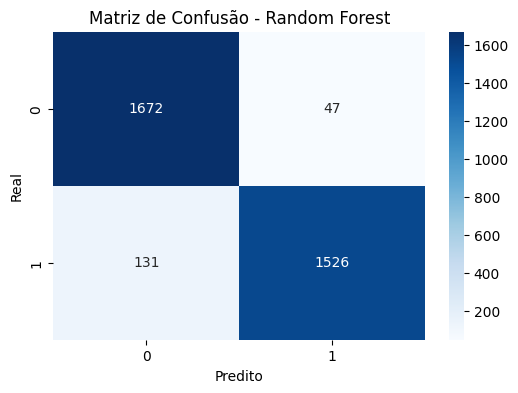

In [19]:
# 7. Avaliação dos Modelos
## 7.1. Avaliação do Random Forest
y_pred_rf = grid_rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Matriz de Confusão
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1719
           1       0.88      0.95      0.92      1657

    accuracy                           0.91      3376
   macro avg       0.92      0.91      0.91      3376
weighted avg       0.92      0.91      0.91      3376



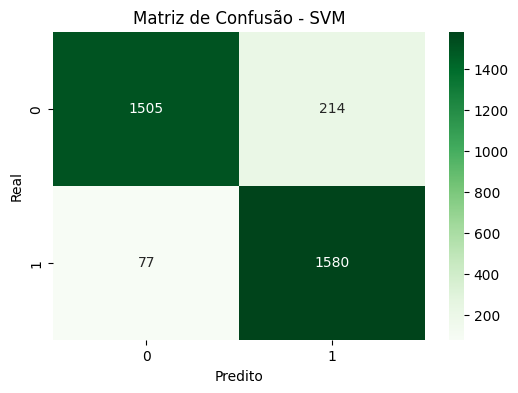

In [20]:
## 7.2. Avaliação do SVM
y_pred_svc = grid_svc.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svc))

# Matriz de Confusão
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão - SVM')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [21]:
# 8. Seleção e Treinamento do Modelo Final
# Com base nas métricas, selecionamos o modelo com melhor desempenho. Suponhamos que o Random Forest teve melhor desempenho.
# Treinando o modelo final com os melhores parâmetros encontrados
final_model = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
final_model.fit(X_scaled, y_res)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [22]:
# 9. Salvando o Modelo e o Scaler
# Salvando o modelo
with open('final_motor_failure_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

# Salvando o scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [23]:
# 10. Implementação do Modelo em Produção
## 10.1. Carregando o Modelo e o Scaler
# Carregando o modelo salvo
with open('final_motor_failure_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Carregando o scaler salvo
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

In [24]:
## 10.2. Preparação dos Dados de Entrada

# Carregando os dados originais com a coluna 'failure'
data_original = pd.read_csv('motor_temperature_data.csv')

# Simulando novos dados com as últimas 1000 amostras
new_data = data_original.tail(1000).copy()

# Removendo a coluna 'failure' para simular dados sem o rótulo
new_data = new_data.drop('failure', axis=1)

# Recalculando as features de tendência
new_data['pm_diff'] = new_data['pm'].diff().fillna(0)
new_data['pm_rate'] = new_data['pm_diff'] / (new_data['timestamp'].diff().fillna(1))

# Selecionando as features
X_new = new_data[features]

# Tratando dados faltantes
X_new.fillna(X_new.mean(), inplace=True)

# Padronizando os dados
X_new_scaled = scaler.transform(X_new)

In [25]:
## 10.3 - Fazendo previsões
# Fazendo previsões
predictions = model.predict(X_new_scaled)

# Adicionando as previsões ao DataFrame
new_data['failure_prediction'] = predictions

In [26]:
## 10.4 - Sistema de Alerta
# Identificando instâncias onde há previsão de falha
motors_at_risk = new_data[new_data['failure_prediction'] == 1]

# Função para enviar alerta
def send_alert(index, data_row):
    print(f"Alerta: Possível falha detectada na amostra {index}.")

# Enviando alertas
for index, row in motors_at_risk.iterrows():
    send_alert(index, row)

Alerta: Possível falha detectada na amostra 9013.
Alerta: Possível falha detectada na amostra 9023.
Alerta: Possível falha detectada na amostra 9026.
Alerta: Possível falha detectada na amostra 9028.
Alerta: Possível falha detectada na amostra 9032.
Alerta: Possível falha detectada na amostra 9051.
Alerta: Possível falha detectada na amostra 9052.
Alerta: Possível falha detectada na amostra 9065.
Alerta: Possível falha detectada na amostra 9067.
Alerta: Possível falha detectada na amostra 9071.
Alerta: Possível falha detectada na amostra 9075.
Alerta: Possível falha detectada na amostra 9084.
Alerta: Possível falha detectada na amostra 9096.
Alerta: Possível falha detectada na amostra 9101.
Alerta: Possível falha detectada na amostra 9107.
Alerta: Possível falha detectada na amostra 9130.
Alerta: Possível falha detectada na amostra 9134.
Alerta: Possível falha detectada na amostra 9145.
Alerta: Possível falha detectada na amostra 9152.
Alerta: Possível falha detectada na amostra 9154.
